## Fundamenetals of Social Data Science.

# Week 3. Day 1. Distance 1. Spatial analysis

**Learning goals**:

- Understand the relationship between a GeoDataFrame, a Coordinate, and a Shapefile.
- Be able to parse a coordinate using Wikipedia.
- Understand the notion of a distance matrix.
  - Deploy such a matrix to determine the closest and furthest points.
- Be able to plot coordinates on a map.
- Understand the use of a spatial join to link coordinates to larger shapes.
- Be able to look up free text and get its coordinates.

Extending this in the exercise in an optional lab session:

- Understand the multiple ways in which we can query Wikipedia for coordinates
- Plot both points and shapes on a map

Today we are starting our exploration of distance. This will start with what might be the most intuitively direct notion of distance: that of spatial distance. To do this will also involve an introduction to some spatial packages in Python. Depending on your own analysis, spatial distances may or may not be useful, but they help us introduce the notion of points and distances.

Below we will need to create a new virtual environment for this. You can see the virtual environment details in the GitHub for this project: https://github.com/berniehogan/oii-fsds-distance. There will be new things in the requirements.txt from last time and with any luck these will all download and install with little issue. Today we will briefly show the use of the following:

- `GeoDataFrame`: This is like a regular DataFrame except it has a `geometry` column.
- `Shapely`: This is a library for polygons. Countries, states, landmarks, etc...can all be thought of as polygons. Thus, in the `geometry` column will not be lat-long coordinates but a shapely object, such as `Polygon`, `MultiPolygon`, `Point` and `Multipoint`.
- `cartopy`: This is a library for doing calculations based on different map projections. Since the earth is like a sphere (an oblate spheroid, in fact), rendering planar objects like maps can lead to very different impressions depending on the way the surface of the sphere is flattened into a map.

Below we start by showing how to transform a single lat-long point into a `Point` and add it to a GeoDataFrame.


In [35]:
# Remember to check your imports first!
# python -m .venv venv
# source .venv/bin/activate
# pip install -r requirements.txt
# python -m ipykernel install --user --name=.venv

import os
import ssl
import certifi
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd
import requests
import cartopy.crs as ccrs
import numpy as np
import geopy.geocoders
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

CERT_PATH = certifi.where()
ctx = ssl.create_default_context(cafile=CERT_PATH)
geopy.geocoders.options.default_ssl_context = ctx

In [2]:
# Create a point for Oxford, UK (approximate coordinates)
lat, lon = 51.7520, -1.2577
oxford_point = Point(lon, lat)  # Note: GeoPandas expects (longitude, latitude)

# Create a GeoDataFrame with the point
point_gdf = gpd.GeoDataFrame(
    {'city': ['Oxford']},
    geometry=[oxford_point],
    # crs="EPSG:4326"  # Standard coordinate system for GPS coordinates
)

display(point_gdf)

,city,geometry
0,Oxford,POINT (-1.2577 51.752)


With this single point we can make a map. In fact, we can make a map with no points, all we need is a 'shapefile'. Different shape files will refer to different areas of the world (or of other worlds, sometimes). We will first download a simple one with a custom `download_world_boundaries()` method.

Then observe how I use standard matplotlib to plot the world, then to plot a point along with the world, and then to filter the map down to a closer area.


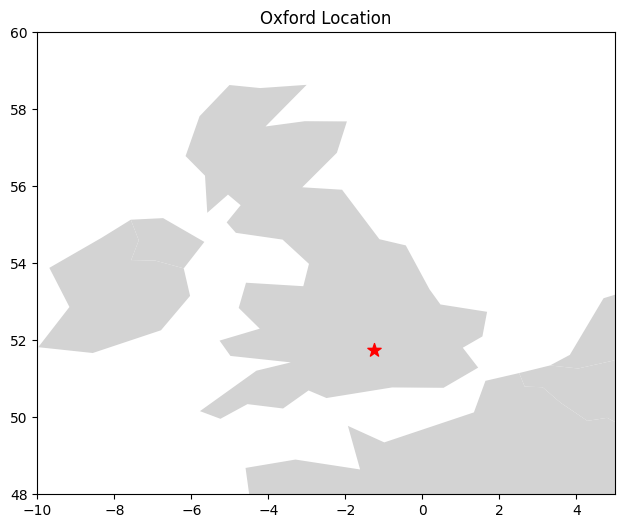

In [6]:
def download_world_boundaries():
    """
    Download and load Natural Earth world boundaries data
    """
    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

    if not os.path.exists('data'):
        os.makedirs('data')

    zip_path = "data/world_boundaries.zip"
    if not os.path.exists(zip_path):
        print("Downloading world boundaries data...")
        response = requests.get(url)
        with open(zip_path, 'wb') as f:
            f.write(response.content)

    world = gpd.read_file(f"zip://{zip_path}")
    return world


# Download and create world map
world = download_world_boundaries()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the world
world.plot(ax=ax, color='lightgrey')

# STEP 2: Uncomment the point and title
# Plot the point
point_gdf.plot(ax=ax, color='red', marker='*', markersize=100)
plt.title('Oxford Location')

# STEP 3: Uncomment the map bounds
# Set map bounds to focus on UK/Western Europe
# Longitude:
ax.set_xlim([-10, 5])
# Latitude:
ax.set_ylim([48, 60])
plt.show()

Now that we have shown a single point, let's continue to look at a few points. We will do this with some landmarks from Wikipedia. First we will download the landmarks using the Wikipedia API, then add them to a GeoDataFrame, and finally plot these points. Thereafter, we will look at these points on a distance matrix.


In [7]:
def create_geodataframe(article_list):
    """
    Create a GeoDataFrame from a list of Wikipedia articles
    """
    data = []
    for article in articles:
        result = get_wiki_coordinates(article)
        if result and result["latitude"] and result["longitude"]:
            data.append(result)

    df = pd.DataFrame(data)
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

    return gdf


def get_wiki_coordinates(article_title):
    """
    Extract coordinates from a Wikipedia page using the API
    """
    try:
        url = "https://en.wikipedia.org/w/api.php"
        params = {
            "action": "query",
            "titles": article_title,
            "prop": "coordinates|revisions",
            "format": "json"
        }
        response = requests.get(url, params=params)
        data = response.json()

        page = next(iter(data["query"]["pages"].values()))
        coords = page.get("coordinates", [{}])[0]
        revision_id = page["revisions"][0]["revid"]

        return {
            "title": article_title,
            "latitude": coords.get("lat"),
            "longitude": coords.get("lon"),
            "revision_id": revision_id
        }
    except Exception as e:
        print(f"Error processing {article_title}: {str(e)}")
        return None


articles = [
    "Eiffel Tower",
    "Taj Mahal",
    "Statue of Liberty",
    "Sydney Opera House",
    "Colosseum",
    "Petra",
    "Machu Picchu",
    "Great Pyramid of Giza"]

geo_df = create_geodataframe(articles)

display(geo_df)

,title,latitude,longitude,revision_id,geometry
0,Eiffel Tower,48.858222,2.294500,1253782042,POINT (2.2945 48.85822)
1,Taj Mahal,27.175000,78.041944,1249822473,POINT (78.04194 27.175)
2,Statue of Liberty,40.689167,-74.044444,1253679586,POINT (-74.04444 40.68917)
3,Sydney Opera House,-33.856810,151.215140,1253162730,POINT (151.21514 -33.85681)
4,Colosseum,41.890278,12.492222,1253554256,POINT (12.49222 41.89028)
5,Machu Picchu,-13.163333,-72.545556,1253163275,POINT (-72.54556 -13.16333)
6,Great Pyramid of Giza,29.979167,31.134167,1252643905,POINT (31.13417 29.97917)


Map saved to figures/wiki_locations.png


(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Locations of Wikipedia Articles'}, xlabel='Longitude', ylabel='Latitude'>)

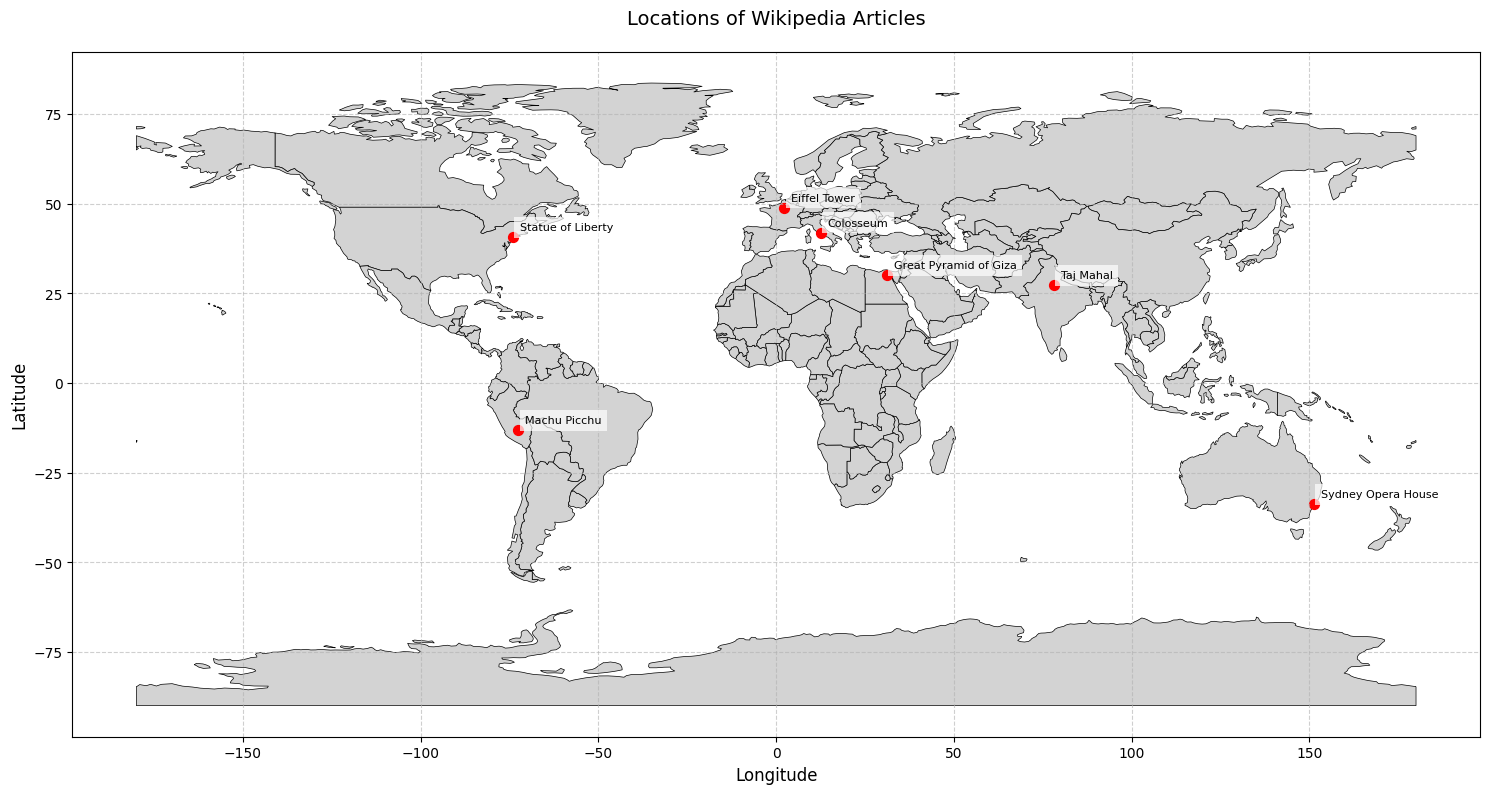

In [8]:
def plot_locations(gdf, save_path=None):
    """
    Create a static map using matplotlib
    """
    world = download_world_boundaries()

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot world boundaries
    world.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)

    # Plot points
    gdf.plot(ax=ax, color='red', markersize=50)

    # Add labels for each point
    for _, row in gdf.iterrows():
        # Get a representative point depending on geometry type
        if row.geometry.geom_type == 'Point':
            x, y = row.geometry.x, row.geometry.y
        else:
            # For MultiPoints, Polygons, etc. use representative_point() or centroid
            point = row.geometry.representative_point()  # or row.geometry.centroid
            x, y = point.x, point.y

        ax.annotate(
            row['title'],
            xy=(x, y),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=8,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
        )

    # Customize the plot
    ax.set_title('Locations of Wikipedia Articles', fontsize=14, pad=20)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

    # Add gridlines
    ax.grid(True, linestyle='--', alpha=0.6)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    if save_path:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Map saved to {save_path}")

    return fig, ax


plot_locations(geo_df, save_path='figures/wiki_locations.png')

# Spatial operations with Points

Now that we can see a list of points on a map, we can have some confidence that these points are where we expected. Yet, we know these points would be embedded in larger polygons such as countries. We also may be interested in the relative distance of these points. Below we see three operations, the first is a spatial join, the second is a distance matrix, and the third is 'entity resolution'.

## Spatial joins

The spatial join will link these points to a larger area. In this case we are doing a spatial join to a country which is relatively simple. In applied work we may want to spatially join these points to areas for which we have other data. For example, instead of 7 points of the world, we might have a set of registered landmarks, a set of counties or boroughs, and a table of funding per bureau. In such cases, we are interested in which points are in which boroughs. Do the boroughs with more funding have more registered landmarks? We can think of this with crime data, protests, organic stores, cases for infections, etc...The point is that we often have metrics at one scale and measurements at another scale. Thus, we end up with something like our one-to-many joins, except they are about joining points to polygons.


In [9]:
def spatial_operations(points_gdf, world_shapefile='data/world_boundaries.zip'):
    """
    Perform spatial operations on the GeoDataFrame
    """
    if not os.path.exists(world_shapefile):
        world = download_world_boundaries()
    else:
        world = gpd.read_file(world_shapefile)

    joined = gpd.sjoin(
        points_gdf, world[['NAME', 'geometry']], how='left', predicate='within')
    joined = joined.rename(columns={'NAME': 'country'})

    return joined  # , distance_matrix


joined_df = spatial_operations(geo_df)
display(joined_df[['title', 'country']])

,title,country
0,Eiffel Tower,France
1,Taj Mahal,India
2,Statue of Liberty,United States of America
3,Sydney Opera House,Australia
4,Colosseum,Italy
5,Machu Picchu,Peru
6,Great Pyramid of Giza,Egypt


Depending on the nature of your own work, this join might be a little more tricky but this is the basic logic by which we can locate points within larger polygons. This is especially useful if we have polygon-level data about something.


# Spatial distance matrix

In our later work, we will want to be digging deep in to distance matrices but these will end up being abstract distances. Like how far is the word "dog" from the words "cat" and "pet". Which word is closer to pet? It's rather absract but we can certainly do it with enough data and finesse. Before we get there, let's think about a more prosaic form of distance matrix: spatial points.

Let's say we wanted to do a trip to see some of these wonders of the world and wanted to keep the trip simple. Naively using distance on the globe we might want to know which two points are closest to each other. This approach below will calculate every point's distance to every other point. It is not especially efficient to do this when there might be reasonable forms of approximation for relatively large sets of points. It is also not 'practical distance' since that would require knowing about roads and train journeys etc... But it is a start.

This is a good opportunity to have a look at some differences between DataFrames as rich tables with cases in rows and variables in columns towards matrices and vectors in `numpy` which tend more towards data as we might see it in mathematics.


In [10]:
# Here are the long-lat coordinates of the points as a NumPy array
coords = np.array([[p.x, p.y] for p in geo_df.geometry])
display(coords)

array([[  2.2945    ,  48.85822222],
       [ 78.04194444,  27.175     ],
       [-74.04444444,  40.68916667],
       [151.21514   , -33.85681   ],
       [ 12.49222222,  41.89027778],
       [-72.54555556, -13.16333333],
       [ 31.13416667,  29.97916667]])

To make a distance matrix with these we can envision it as a 7 by 7 matrix with the names in both the rows and the columns.

Then we can iterate by row and column and fill in the values for each of the 49 possible distances. I use the `geopy` package in python which will account for the spherical shape of the earth. For each of the 49 cells we can use `geopy.distance.geodesic`. Also, we can transform these distances to kilometers right in the formula:

`two_points_distance = geodesic((lat_1, long_1), (lat_2, long_2)).kilometers`

Observe this function below:


In [11]:
from geopy.distance import geodesic


def get_distance_matrix_geopy(coords):
    """
    Calculate distance matrix using geopy's geodesic distance.
    Input: numpy array of [longitude, latitude] pairs
    Output: distance matrix in kilometers
    """
    n = len(coords)
    distances = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            # Note: geodesic expects (latitude, longitude)
            distances[i, j] = geodesic(
                (coords[i, 1], coords[i, 0]),
                (coords[j, 1], coords[j, 0])
            ).kilometers

    return distances


result = get_distance_matrix_geopy(coords)
display(result)

array([[    0.        ,  6771.72786495,  5853.10942099, 16960.88835749,
         1110.73591006, 10022.751023  ,  3215.22696776],
       [ 6771.72786495,     0.        , 11959.4216331 , 10253.48351154,
         6084.27176691, 16596.60588683,  4567.96591748],
       [ 5853.10942099, 11959.4216331 ,     0.        , 15983.55295615,
         6912.14848043,  5963.84326123,  9042.75109419],
       [16960.88835749, 10253.48351154, 15983.55295615,     0.        ,
        16320.91035092, 13048.80945731, 14422.87033719],
       [ 1110.73591006,  6084.27176691,  6912.14848043, 16320.91035092,
            0.        , 10572.70584856,  2131.09456346],
       [10022.751023  , 16596.60588683,  5963.84326123, 13048.80945731,
        10572.70584856,     0.        , 12041.38590829],
       [ 3215.22696776,  4567.96591748,  9042.75109419, 14422.87033719,
         2131.09456346, 12041.38590829,     0.        ]])

Notice in the function we were using `numpy` arrays directly, referencing the specific cells with just integers that we derived from our `for` loops. Also, we were indexing cells of an existing array of the correct shape. This was first created with `np.zeros(<shape>)`. The shape of an array can have an arbitrary depth, so it's a single object. In this case it's a simple 7 \* 7 matrix.

With numpy arrays we do not get the niceties of DataFrames in terms of indices and column labels. Consequently, we might get a bit lost with the next step if we are not careful. I will show how this is done with a numpy array and a dataframe. But first, let's convert this matrix into a DataFrame to view the results:


In [12]:
distance_df = pd.DataFrame(
    result, index=geo_df['title'], columns=geo_df['title'])
display(distance_df)

title,Eiffel Tower,Taj Mahal,Statue of Liberty,Sydney Opera House,Colosseum,Machu Picchu,Great Pyramid of Giza
title,,,,,,,
Eiffel Tower,0.000000,6771.727865,5853.109421,16960.888357,1110.735910,10022.751023,3215.226968
Taj Mahal,6771.727865,0.000000,11959.421633,10253.483512,6084.271767,16596.605887,4567.965917
Statue of Liberty,5853.109421,11959.421633,0.000000,15983.552956,6912.148480,5963.843261,9042.751094
Sydney Opera House,16960.888357,10253.483512,15983.552956,0.000000,16320.910351,13048.809457,14422.870337
Colosseum,1110.735910,6084.271767,6912.148480,16320.910351,0.000000,10572.705849,2131.094563
Machu Picchu,10022.751023,16596.605887,5963.843261,13048.809457,10572.705849,0.000000,12041.385908
Great Pyramid of Giza,3215.226968,4567.965917,9042.751094,14422.870337,2131.094563,12041.385908,0.000000


Previously we looked at one way in which we can reshape data from long to wide format: `explode()`. This involved having a list in a DataFrame column. Now below we can see a different way to reshape the data. We want to take each cell and make a row for the row-title and the col-title. So our table looks like:
| Source | Destination | Distance |
|--------------|-|-|
| Eiffel Tower | Taj Mahal | 0.012692 |

If we keep the data in a numpy array, we can use `np.column_stack()`, if we work on the pandas DataFrame, we can use `df.melt()`. The specific syntax is tricky and I made use of copilot for the function based on specifications. Here is the core command in `pandas`:


In [13]:
long_df = distance_df.reset_index().melt(
    id_vars='title', var_name='destination', value_name='distance')

print(f"The distance DataFrame has {len(long_df)} rows.")

display(long_df.head())

The distance DataFrame has 49 rows.


,title,destination,distance
0,Eiffel Tower,Eiffel Tower,0.000000
1,Taj Mahal,Eiffel Tower,6771.727865
2,Statue of Liberty,Eiffel Tower,5853.109421
3,Sydney Opera House,Eiffel Tower,16960.888357
4,Colosseum,Eiffel Tower,1110.735910


`df.reset_index()` is because we have rows and columns both called `'title'`. We want to melt only one of these. So we reset the index and melt the columns. Then for each column we will have that column's title (such as "Colosseum") and then one row for each of the rows that is there like:
| Source | Destination | Distance |
|--------------|-|-|
| Colosseum | Taj Mahal | 0.014885 |

Notice unfortunately we now have 49 rows (7 \* 7). But if source and destination are the same it is trivial. Also, since Source | Dest is the same distance as Dest | Source, we do not need it there twice. So let's perform a couple operations on this, first getting rid of the trivial cases (source == dest), and then ensuring we only have a unique column for each dyad.

49 - 7 (for the diagonal) = 42. Then divide by two = 21. This actually is a well known formula in networks for the maximum edges of a connected undirected graph.

$$
\text{max\_edges} = \frac{n(n-1)}{2}
$$


In [20]:
long_df = long_df[long_df['title'] != long_df['destination']]

# Ensure only one row per dyad by sorting and dropping duplicates
long_df['pair'] = long_df.apply(lambda row: tuple(
    sorted([row['title'], row['destination']])), axis=1)
long_df = long_df.drop_duplicates(subset='pair').drop(columns='pair')

print(f"The distance DataFrame now has {len(long_df)} rows.")

The distance DataFrame now has 21 rows.


In [21]:
display(long_df)

,title,destination,distance
1,Taj Mahal,Eiffel Tower,6771.727865
2,Statue of Liberty,Eiffel Tower,5853.109421
3,Sydney Opera House,Eiffel Tower,16960.888357
4,Colosseum,Eiffel Tower,1110.735910
5,Machu Picchu,Eiffel Tower,10022.751023
6,Great Pyramid of Giza,Eiffel Tower,3215.226968
9,Statue of Liberty,Taj Mahal,11959.421633
10,Sydney Opera House,Taj Mahal,10253.483512
11,Colosseum,Taj Mahal,6084.271767
12,Machu Picchu,Taj Mahal,16596.605887


In [22]:
# Wrapping this up in a function

def calc_distances(gdf, label_col='title', keep_diagonal=False, symmetric=True):
    """
    Calculate distance matrix using geopy's geodesic distance.
    Input: numpy array of [longitude, latitude] pairs
    Output: distance matrix in kilometers
    """

    if label_col not in gdf.columns:
        raise KeyError(
            f"The column '{label_col}' is not present in the GeoDataFrame.")

    labels = gdf[label_col].values
    n = len(labels)
    distances = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            # Note: geodesic expects (latitude, longitude)
            distances[i, j] = geodesic(
                (gdf.geometry.iloc[i].y, gdf.geometry.iloc[i].x),
                (gdf.geometry.iloc[j].y, gdf.geometry.iloc[j].x)
            ).kilometers

    distance_df = pd.DataFrame(
        distances, columns=gdf[label_col], index=gdf[label_col])

    long_df = distance_df.reset_index().melt(
        id_vars=label_col, var_name='destination', value_name='distance')

    if not keep_diagonal:
        long_df = long_df[long_df[label_col] != long_df['destination']]
    if symmetric:
        long_df['pair'] = long_df.apply(lambda row: tuple(
            sorted([row[label_col], row['destination']])), axis=1)
        long_df = long_df.drop_duplicates(subset='pair').drop(columns='pair')

    return long_df


long_df = calc_distances(geo_df, label_col='title')

display(long_df.sort_values('distance', ascending=False).head())

,title,destination,distance
3,Sydney Opera House,Eiffel Tower,16960.888357
12,Machu Picchu,Taj Mahal,16596.605887
25,Colosseum,Sydney Opera House,16320.910351
17,Sydney Opera House,Statue of Liberty,15983.552956
27,Great Pyramid of Giza,Sydney Opera House,14422.870337


Before concluding, I wanted to point out how one can get stuck in a rut and how this can lead to less efficient coding including with the use of LLMs. The above code was anchored on the idea that we had to fill out the complete matrix, and then reshape it somehow. But we only needed the upper triangle of the matrix to begin with. Look below how simple the operations become when we only loop over `n` and `n+1`, rather than loop through all the cells. We can just create a list rather than a distance matrix. We can return to that distance matrix later if needed, but this will depend on our work. If we just want the rank order of distances, this code below is far quicker, which we can show with %timeit.

Hence, there are many ways to approach this task but often trying to use basic python operations, external functions, and simple data structures ends up being both the most robust and elegant.


In [23]:
def calc_distances_long(gdf, label_col='title'):
    """
    Calculate distances efficiently, returning only unique pairs
    """
    distances = [
        (gdf[label_col].iloc[i],
         gdf[label_col].iloc[j],
         geodesic(
            (gdf.geometry.iloc[i].y, gdf.geometry.iloc[i].x),
            (gdf.geometry.iloc[j].y, gdf.geometry.iloc[j].x)
        ).kilometers)
        for i in range(len(gdf))
        for j in range(i+1, len(gdf))
    ]

    return pd.DataFrame(distances, columns=['source', 'dest', 'distance'])


display(calc_distances_long(geo_df).sort_values(
    "distance", ascending=False).head())

,source,dest,distance
2,Eiffel Tower,Sydney Opera House,16960.888357
9,Taj Mahal,Machu Picchu,16596.605887
15,Sydney Opera House,Colosseum,16320.910351
11,Statue of Liberty,Sydney Opera House,15983.552956
17,Sydney Opera House,Great Pyramid of Giza,14422.870337


# Spatial lookups

With the Wikipedia API we were able to look up the locations via the API, parse them appropriately and then get the lat long coordinates. But what if we have a situation where we have a column of data, such as the user location field in Stack Exchange, and we wanted to look up the coordinates from free text? Fortunately services exist for this, but I must say this with caution as they are often _rate-limited_ and/or paid. However, for demonstration purposes, we can use OpenStreetMap's `nominatim` API through the geopy package to show its use. Notice that I try with "London, UK", "Somewhere on Earth", and "Google Headquarters". I will leave it to you to explore a spatial join to Google Headquarters to see if it is really in Mountain View, Ca.


In [36]:
geolocator = Nominatim(user_agent="educational_demo_student")


def get_coordinates(location_str="London, UK"):
    try:
        location = geolocator.geocode(location_str)
        return (location.latitude, location.longitude) if location else None
    except GeocoderTimedOut:
        print("The request timed out")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


# Example usage
locations = ["Oxford, UK",
             "Somewhere on Earth",
             "Google Headquarters"]

for location in locations:
    coords = get_coordinates(location)
    print(f"Coordinates for {location}: {coords}")

Coordinates for Oxford, UK: (51.7520131, -1.2578499)
Coordinates for Somewhere on Earth: None
Coordinates for Google Headquarters: (37.4217636, -122.084614)


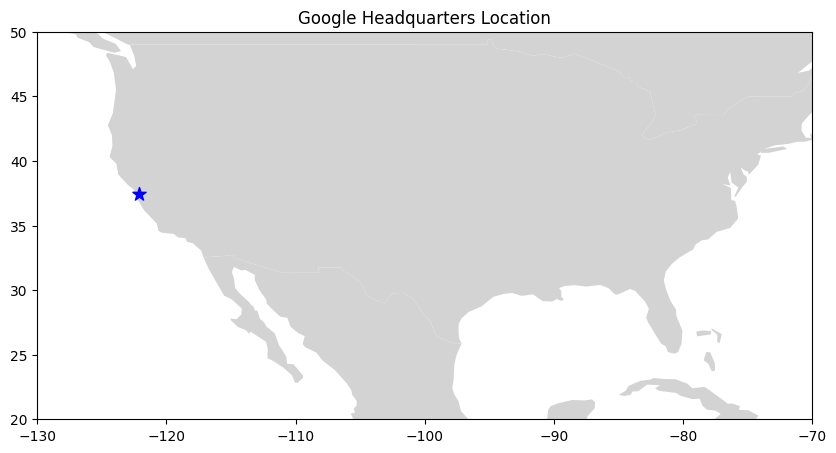

In [45]:
# Get location of Google Headquarters
google_coords = get_coordinates("Google Headquarters")

# Create a GeoDataFrame with the point
google_point = gpd.GeoDataFrame(
    {'city': ['Google Headquarters']},
    geometry=[Point(google_coords[::-1])]
)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the world
world.plot(ax=ax, color='lightgrey')

# Plot the point
google_point.plot(ax=ax, color='blue', marker='*', markersize=100)
plt.title('Google Headquarters Location')

# Set map bounds to focus on US/Western Europe
ax.set_xlim([-130, -70])
ax.set_ylim([20, 50])

plt.show()